In [19]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

"""
Create a Decision Stump
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps


# Load in the data and define the column labels


dataset = pd.read_csv("C:\\Users\\Chinmay\\Documents\\GitHub\\wireless_sensor_networks\\C2\\comaprision of X-MAC and cotinki-MAC\\mushroom_csv.csv",header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
             'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
             'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population',
             'habitat']



# Encode the feature values from strings to integers since the sklearn DecisionTreeClassifier only takes numerical values
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])

    
    
Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1)


X = dataset.drop('target',axis=1)
Y = dataset['target'].where(dataset['target']==1,-1)



predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score'])


print('The accuracy is: ',predictions*100,'%')

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps


# Load in the data and define the column labels


dataset = pd.read_csv(r"C:\Users\Chinmay\Documents\GitHub\wireless_sensor_networks\C2\comaprision of X-MAC and cotinki-MAC\mushroom_csv.csv",header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
             'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
             'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population',
             'habitat']



# Encode the feature values from strings to integers since the sklearn DecisionTreeClassifier only takes numerical values
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label].astype('str')).transform(dataset[label].astype('str'))
int
    
    
Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1)


X = dataset.drop('target',axis=1)
Y = dataset['target'].where(dataset['target']==1,-1)



predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score'])


print('The accuracy is: ',predictions*100,'%')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=100.
  warnings.warn(("The least populated class in y has only %d"


The accuracy is:  99.95121951219512 %


With a number of  50 base models we receive an accuracy of  99.95076923076923 %


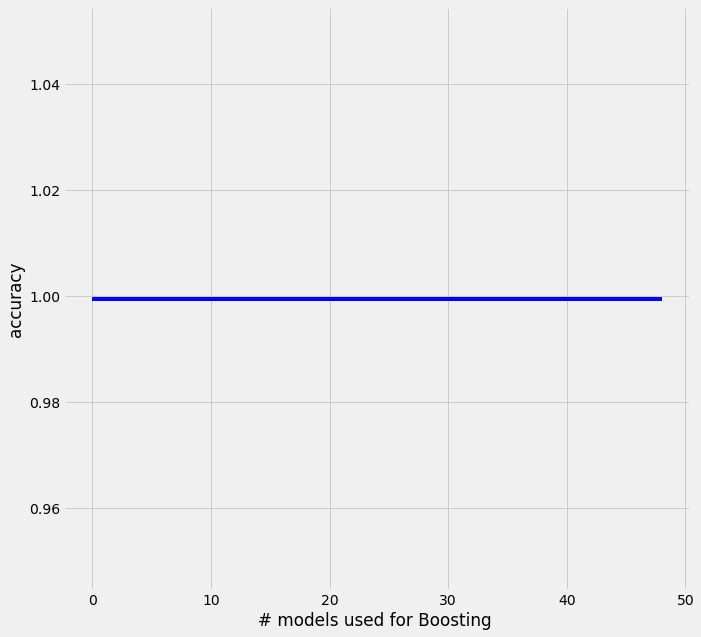

In [28]:
class Boosting:

    def __init__(self,dataset,T,test_dataset):
        self.dataset = dataset
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.accuracy = []
        self.predictions = None
    
    def fit(self):
        # Set the descriptive features and the target feature
        X = self.dataset.drop(['target'],axis=1)
        Y = self.dataset['target'].where(self.dataset['target']==1,-1)

        # Initialize the weights of each sample with wi = 1/N and create a dataframe in which the evaluation is computed
        Evaluation = pd.DataFrame(Y.copy())
        Evaluation['weights'] = 1/len(self.dataset) # Set the initial weights w = 1/N
        

        # Run the boosting algorithm by creating T "weighted models"
        
        alphas = [] 
        models = []
        
        for t in range(self.T):

            # Train the Decision Stump(s)
            Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) # Mind the deth one --> Decision Stump
            
            # We know that we must train our decision stumps on weighted datasets where the weights depend on the results of
            # the previous decision stumps. To accomplish that, we use the 'weights' column of the above created 
            # 'evaluation dataframe' together with the sample_weight parameter of the fit method.
            # The documentation for the sample_weights parameter sais: "[...] If None, then samples are equally weighted."
            # Consequently, if NOT None, then the samples are NOT equally weighted and therewith we create a WEIGHTED dataset 
            # which is exactly what we want to have.
            model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights'])) 
            
            # Append the single weak classifiers to a list which is later on used to make the 
            # weighted decision
            models.append(model)
            predictions = model.predict(X)
            score = model.score(X,Y)

            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['target'],1,0)
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['target'],1,0)

            # Calculate the misclassification rate and accuracy
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])


            # Caclulate the error
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
 
   
            # Calculate the alpha values
            alpha = np.log((1-err)/err)
            alphas.append(alpha)


            # Update the weights wi --> These updated weights are used in the sample_weight parameter
            # for the training of the next decision stump. 
            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])

            #print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
            #print('The missclassification rate is: ',misclassification*100,'%')
        
        self.alphas = alphas
        self.models = models
            
    def predict(self):
        X_test = self.test_dataset.drop(['target'],axis=1).reindex(range(len(self.test_dataset)))
        Y_test = self.test_dataset['target'].reindex(range(len(self.test_dataset))).where(self.dataset['target']==1,-1)
    
        # With each model in the self.model list, make a prediction 
        
        accuracy = []
        predictions = []
        
        for alpha,model in zip(self.alphas,self.models):
            prediction = alpha*model.predict(X_test) # We use the predict method for the single decisiontreeclassifier models in the list
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]))
            # The above line of code could be a little bit confusing and hence I will do up the single steps:
            # Goal: Create a list of accuracies which can be used to plot the accuracy against the number of base learners used for the model
            # 1. np.array(predictions) --> This is the array which contains the predictions of the single models. It has the shape 8124xn
            # and hence looks like [[0.998,0.87,...0.87...],[...],[...],[0.99,1.23,...,1.05,0,99...]] 
            # 2. np.sum(np.array(predictions),axis=0) --> Summs up the first elements of the lists, that is 0,998+...+...+0.99. This is 
            # done since the formula for the prediction wants us to sum up the predictions of all models for each instance in the dataset. 
            # Hence if we have for example 3 models than the predictions array has the shape 8124x3 (Imagine a table with 3 columns and
            # 8124 rows). Here the first column containst the predictions for the first model, the second column contains the 
            # prediction for the second model, the third column the prediction for the third model (mind that the
            # second and third model are influenced by the results of the first resoectvely the first and the
            # second model). This is logical since the results from column (model)
            # n-1 are used to alter the weights of the nth model and the results of the nth model are then used to alter the weights
            # of the n+1 model. 
            # 3. np.sign(np.sum(np.array(predictions),axis=0)) --> Since our test target data are elements of {-1,1} and we want to 
            # have our prediction in the same format, we use the sign function. Hence each column in the accuracy array is like
            # [-0.998,1.002,1.24,...,-0.89] and each element represents the combined and weighted prediction of all models up this column
            # (so if we are for instance in the 5th column and for the 4th instnace we find the value -0.989, this value represents the 
            # weighted prediction of a boosted model with 5 base learners for the 4th instance. The 4th instance of the 6th column represents
            # the weighted and combined predictions of a boosted model with 6 base learners while the 4th instance of the 4th column represents
            # the predction of a model with 4 base learners and so on and so forth...). To make a long story short, we are interested in the 
            # the sign of these comined predictions. If the sign is positive, we know that the true prediction is more likely postive (1) then
            # negaive (-1). The higher the value (postive or negative) the more likely it is that the model returns the correct prediction.
            # 4. np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]) --> With the last step we have transformed the array 
            # into the shape 8124x1 where the instances are elements {-1,1} and therewith we are now in the situation to compare this 
            # prediction with our target feature values. The target feature array is of the shape 8124x1 since for each row it contains
            # exactly one prediction {-1,1} just as our just created array above --> Ready to compare ;).
            # The comparison is done with the == Y_test.values command. As result we get an 
            # array of the shape 8124x1 where the instances are elements of {True,False} (True if our prediction is consistent with the 
            # target feature value and False if not). Since we want to calculate a percentage value we have to calculate the fraction of 
            # instances which have been classified correctly. Therefore we simply sum up the above comparison array 
            # with the elements {True,False} along the axis 0.
            # and divide it by the total number of rows (8124) since True is the same as 1 and False is the same as 0. Hence correct predictions 
            # increase the sum while false predictions does not change the sum. If we predicted nothing correct the calculation is 0/8124 and 
            # therewith 0 and if we predicted everything correct, the calculation is 8124/8124 and thereiwth 1. 
            # 5. self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0])) -->
            # After we have computed the above steps, we add the result to the self.accuracy list. This list has the shape n x 1, that is,
            # for a model with 5 base learners this list has 5 entries where the 5th entry represents the accuracy of the model when all
            # 5 base learners are combined, the 4th element the accuracy of the model when 4 base learners are combined and so on and so forth. This 
            # procedure has been explained above. That's it and we can plot the accuracy.
        self.predictions = np.sign(np.sum(np.array(predictions),axis=0))

   
        

        


######Plot the accuracy of the model against the number of stump-models used##########

number_of_base_learners = 50

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


for i in range(number_of_base_learners):
    model = Boosting(dataset,i,dataset)
    model.fit()
    model.predict()

ax0.plot(range(len(model.accuracy)),model.accuracy,'-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',model.accuracy[-1]*100,'%')    
                 
plt.show()        



In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])
    
X = dataset.drop(['target'],axis=1)
Y = dataset['target']

#model = DecisionTreeClassifier(criterion='entropy',max_depth=1)
#AdaBoost = AdaBoostClassifier(base_estimator= model,n_estimators=400,learning_rate=1)

AdaBoost = AdaBoostClassifier(n_estimators=400,learning_rate=1,algorithm='SAMME')

AdaBoost.fit(X,Y)

prediction = AdaBoost.score(X,Y)

print('The accuracy is: ',prediction*100,'%')

The accuracy is:  45.206153846153846 %
